In [116]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [117]:
a_true, b_true = 2, 2
True_value =[a_true, b_true]
x = np.linspace(0.1,1,40)
def mean(theta):
    a,b = theta
    return b**2*np.cos(a*x)*np.exp(-b*x**2)
y_mean = mean([a_true, b_true])
std = .001*abs(max(y_mean))

In [118]:
y_random = np.random.randn(200, len(x)) 

In [119]:
y_sample = y_random * std + y_mean
cov = np.cov(y_sample.T)

In [120]:
import iminuit
from iminuit import Minuit
def lnL(a, b):
    theta = a, b
    y_th = mean(theta)
    inv_cov = np.linalg.inv(cov)
    d = y_sample[0] - y_th
    res = -0.5*np.sum(d*inv_cov.dot(d))
    return res
def lnL_emcee(theta):
    a, b = theta
    return lnL(a, b)
def neg_lnL_minuit(a, b):
    return -lnL(a, b)

In [121]:
minuit = Minuit(neg_lnL_minuit, a = a_true, b= b_true,
                   errordef = 0.5)  
minuit.migrad(),minuit.hesse(),minuit.minos()
cov_minuit = np.array(minuit.matrix())
MLE = [minuit.values['a'], minuit.values['b']]

In [122]:
a = np.array(minuit.params)

In [123]:
a = np.array([minuit.merrors['a']['lower'], minuit.merrors['a']['upper']])

In [124]:
x1,y1,z1 = minuit.mnprofile('b')
x2,y2,z1 = minuit.mnprofile('a')

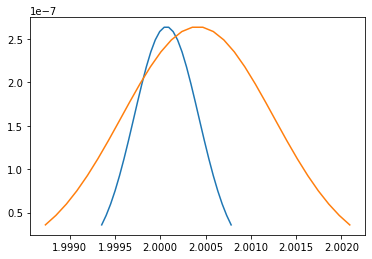

In [125]:
plt.plot(x1,np.exp(-y1))
plt.plot(x2,np.exp(-y2))

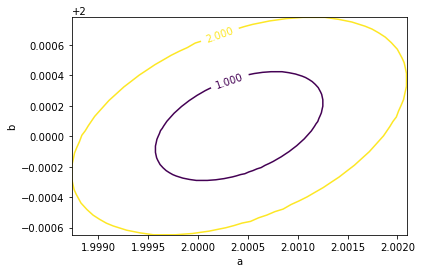

In [126]:
minuit.draw_mncontour("a", "b")

In [127]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/')
import DATAOPS_Fisher_matrix as fisher
forecast = fisher.Forecast()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Test Fisher Matrix Forecast

In [37]:
cov_p_Fisher = np.linalg.inv(forecast.Fisher_Matrix_Gaussian(True_value, mean, cov, delta = 1e-5))
cov_p_Fisher_2 = np.linalg.inv(forecast.Fisher_Matrix_Gaussian(True_value, mean, 4*cov, delta = 1e-5))

In [38]:
cov_p_Fisher

array([[5.28062814e-05, 8.94547370e-06],
       [8.94547370e-06, 1.15079194e-05]])

In [39]:
cov_minuit

array([[5.26122897e-05, 8.90036719e-06],
       [8.90036719e-06, 1.15124388e-05]])

In [24]:
data_1 = np.random.multivariate_normal(True_value, cov_p_Fisher, size=10000)
data_2 = np.random.multivariate_normal(True_value, cov_p_Fisher_2, size=10000)
data_minuit = np.random.multivariate_normal(True_value, cov_minuit, size=10000)

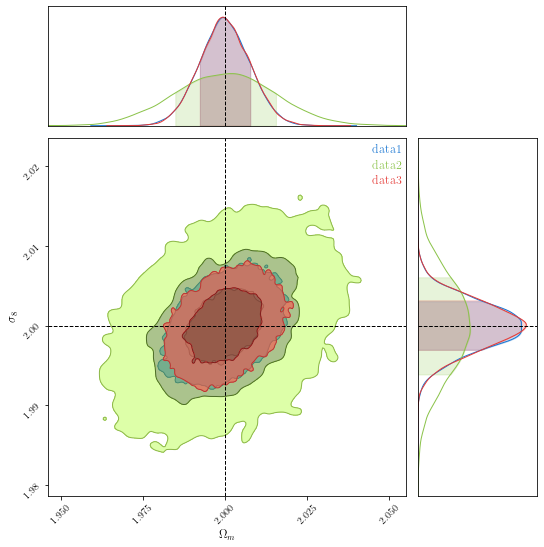

In [25]:
from chainconsumer import ChainConsumer
c = ChainConsumer()
c.add_chain(data_1, name="data1", parameters = [r'$\Omega_m$',r'$\sigma_8$'])
c.add_chain(data_2, name="data2", parameters = [r'$\Omega_m$',r'$\sigma_8$'])
c.add_chain(data_minuit, name="data3", parameters = [r'$\Omega_m$',r'$\sigma_8$'])
c.configure()
fig = c.plotter.plot(truth = True_value)
fig.set_size_inches(5 + fig.get_size_inches()) 
#plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/forecast.png', bbox_inches='tight', dpi=300)

# Test First/Second derivative

In [26]:
True_value_new =[1,1,2]
x = np.linspace(1,3,60)
def mean_new(theta):
    a,b,c = theta
    return b*np.sin(c*x)* np.exp(-a*x)

In [27]:
def mean_new_x(xs):
    a,b,c = True_value_new
    return b*np.sin(c*xs)* np.exp(-a*xs)

In [13]:
second_derivative_p = forecast.second_derivative(True_value_new, mean_new, x.shape)
first_derivative_p = forecast.first_derivative(True_value_new, mean_new, x.shape)

In [14]:
first_derivative_x = forecast.first_derivative(x, mean_new_x, x.shape)
second_derivative_x = forecast.second_derivative(x, mean_new_x, x.shape)

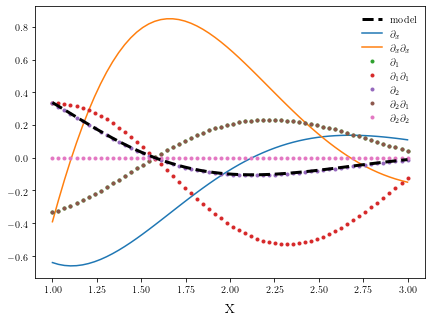

In [15]:
plt.figure(figsize = (7,5))
plt.plot(x, mean_new(True_value_new) - np.mean(mean_new(True_value_new)), '--k', label = 'model', linewidth = 3, zorder = 1000)
plt.plot(x, first_derivative_x.diagonal(),'-', label = r'$\partial_x$')
plt.plot(x, second_derivative_x.diagonal().diagonal(),'-', label = r'$\partial_x\partial_x$')
for i in range(len(True_value)):
    plt.plot(x,first_derivative_p[i], '.', label = f'$\partial_{i+1}$', linewidth = 3)
    for j in range(len(True_value)): 
        if i>=j:
            plt.plot(x,second_derivative_p[i,j],'.', label = f'$\partial_{i+1}\partial_{j+1}$')
plt.legend(frameon = False)
plt.xlabel('x', fontsize = 20)
plt.show()